# Generating simple cross sections

Here we show how you can generate collisional cross sections using the tools from `parfis` module. Since the collisional therms span for a wide range of energy (velocity), we must use nonlinear function tabulation.

$$\newcommand{\Ang}{\unicode{xC5}}$$

## Constant and step collision cross section

Particle's velocity is bounded in value, as it must not traverse more than a cell-length in a single timestep. The larger the cell component (x, y or z) is, the greater maximum velocity it can support. In order to satisfy the constrain for all components, we must choose the smallest component as the base for the calculation of the maximum allowed velocity magnitude. Let's take the following simulation settings:

$$
\begin{align*} 
  C = C_x &= C_y = C_z = 0.002 \mathrm{m}, \\
  \Delta t &= 10^{-11} \mathrm{s}, \\
   m_e &= 9.1093837 \cdot 10^{-31} \mathrm{kg},
\end{align*}
$$

for the cell size, timestep and particle mass (electron). We can calculate the maximum velocity component as $v_m = C/\Delta t$ from which we get the maximum kinetic energy that can be simulated per electron as:

$$
\epsilon_{m} = \frac{m_e v^2}{2} = \frac{m_e C^2}{2 \Delta t ^2} = 1.822\cdot10^{-14} \mathrm{J} \quad (\equiv 113.713 \mathrm{keV}).
$$

From this we see that the x vector can be in the range from 0 to 114keV.

### Constant cross section 

We will generate elastic cross section with a constant value of:

$$\sigma_e = 6 \Ang^2 \quad (\equiv 6.0 \cdot 10^{-20} \mathrm{m^2}).$$

### Step cross section

For the step cross section we have a point at which the value has a discontinity. This cross section will have a threshold, and the collision process is inelastic. The function of the step cross section is:

$$ \sigma_i = 
\begin{cases}
  0 \quad &x < 0.2 \mathrm{eV} \\
  3  \mathrm{\Ang^2} \quad &x \geq 0.2 \mathrm{eV}.
\end{cases}
$$

In [1]:
import parfis as pfs
import matplotlib.pyplot as plt
import numpy as np
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



nbin = 10000 # number of bins
xmax = 114_000
dx = np.log10(xmax)/nbin # dx for the linear axis
xvec = [np.power(i*dx, 10) for i in range(nbin)]

def sigma_e(x):
    return 6

def sigma_i(x):
    if x<0.2:
        return 0
    else:
        return 3

xl = np.asarray(xvec)
yle = np.ndarray(len(xvec), dtype=float)
yli = np.ndarray(len(xvec), dtype=float)
for i in range(len(xvec)):
    yle[i] = sigma_e(xvec[i])
    yli[i] = sigma_i(xvec[i])
ylt = yle + yli

Let's plot the cross section with linear tabulation, with log x-axis scale.

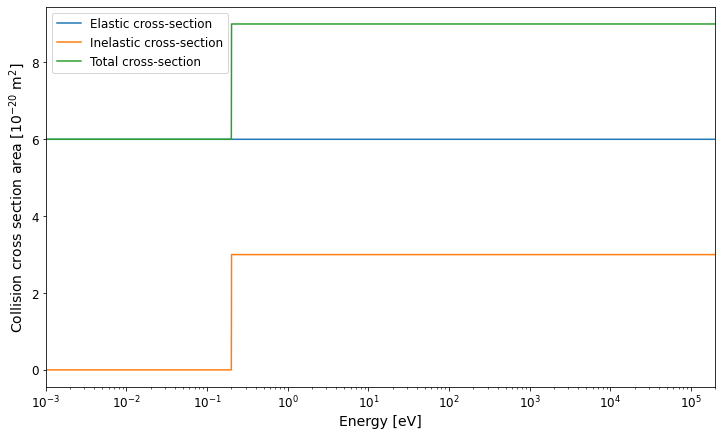

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))  

ax.plot(xl, yle, label="Elastic cross-section")
ax.plot(xl, yli, label="Inelastic cross-section")
ax.plot(xl, ylt, label="Total cross-section")
ax.set_xscale("log")
ax.set_xlim(0.001, 200_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

### Collision frequency

The probability for a collision in a time $\Delta t$ is given as:

$$
p(t, t + \Delta t) = 1 - \exp( -N \sigma_t  v \Delta t ) = 1 - \exp(-\nu_t \Delta_t),
$$

where $N$ is the number of gas particles, $v$ is the velocity magnitude of the projectile particle and $\nu_t$ is the collisional frequency. We can express the above collisional frequencies by using the formula $v = \sqrt{2 \epsilon / m_e}$.

$$
\nu(\epsilon) = N \sigma(\epsilon) v = N \sigma(\epsilon) \sqrt{2 \epsilon/m_e}.
$$

We calculate collisional frequency for Avogadro number of particles $N_A$.

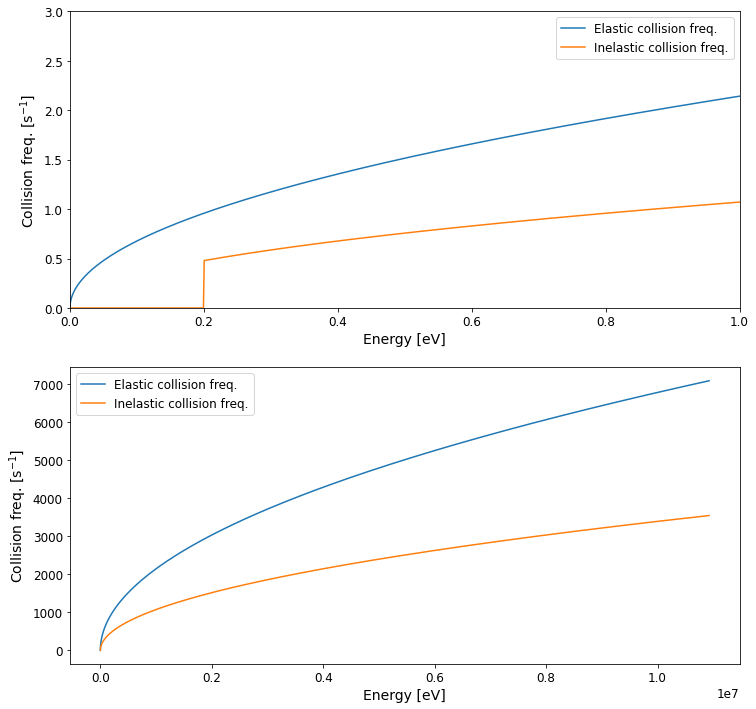

In [3]:
eVJ = 1.602176634e-19
me = 9.1093837e-11  # since we have y in units of A^2 (scale 1e-20m) and me in kg (scale 1e-31)
Na = 6.02214076e23

fle = Na*yle*1e-20*np.sqrt(2*xl*eVJ/me)
fli = Na*yli*1e-20*np.sqrt(2*xl*eVJ/me)

fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(xl, fle, label="Elastic collision freq.")
ax[0].plot(xl, fli, label="Inelastic collision freq.")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 3.0)
ax[0].set_xlabel("Energy [eV]")
ax[0].set_ylabel("Collision freq. [$\mathrm{s}^{-1}$]")
ax[0].legend()
ax[1].plot(xl, fle, label="Elastic collision freq.")
ax[1].plot(xl, fli, label="Inelastic collision freq.")
ax[1].set_xlabel("Energy [eV]")
ax[1].set_ylabel("Collision freq. [$\mathrm{s}^{-1}$]")
ax[1].legend()

plt.show()

## Non-linear function tabulation

Since we are dealing with extremely nonlinear functions we must perform nonlinear tabulation. The mechanism for tabulating is to give ranges and bins for every range of the tabulation. Ranges are connected, for example the range from 0-1 and from 1-10 is written as a list [1, 10]. It can be said that we only write the range's end value, and the startin value is taken to be the previos number in the list. The first element is always zero. Let's see this tabulation for 6 ranges covering the energies from 0 to 114keV, and for 8000 overall datapoints. 

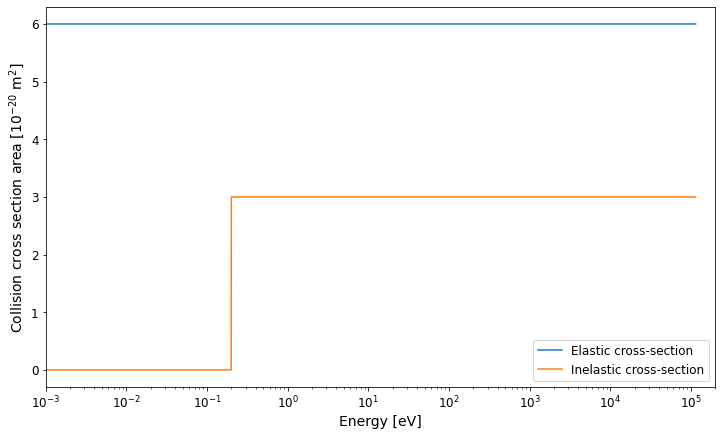

In [4]:
ranges = [   1,   10,  100, 1000, 10000, 114000]
nbins =  [1000, 1000, 1000, 1000,  1000,   3000]

x, ye = pfs.generateCrossSection(sigma_e, ranges, nbins)
x, yi = pfs.generateCrossSection(sigma_i, ranges, nbins)

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(x, ye, label="Elastic cross-section")
ax.plot(x, yi, label="Inelastic cross-section")

ax.set_xscale("log")
ax.set_xlim(0.001, 200_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

## Cross-section and collision frequency

The parfis library is written to accept this nonlinear tabulation for the cross-section data definitions. If we load the following two files, we can represent the collision frequencies as they are calculated in the c++ code. We load the predefined configuration file that loads generated files as given above.

In [5]:
ranges = [   1,   10,  100, 1000, 10000, 114000]
nbins =  [1000, 1000, 1000, 1000,  1000,   1000]
pfs.generateCrossSection(sigma_e, ranges, nbins, file="./elastic.csv")
pfs.generateCrossSection(sigma_i, ranges, nbins, file="./inelastic.csv")

pfs.Parfis.load_lib()
id = pfs.Parfis.newParfis()
pfs.Parfis.setConfigFromFile(id, "./gasCollisionDefinition.ini")
pfs.Parfis.loadCfgData(id)
pfs.Parfis.loadSimData(id)
pfs.Parfis.setPyCfgData(id)
pfs.Parfis.setPySimData(id)
ptrCfgData = pfs.Parfis.getPyCfgData(id)
ptrSimData = pfs.Parfis.getPySimData(id)

Successfully loaded lib file: libparfis64.so


We have the following data for the gas density in mol per square meter and in particles per square meter. We will need the particle mass (in the config file is given in AMU), as weel as the cell size in meters.

In [6]:
Na = 6.02214076e23 # Avogadro number = number of particles in one mol
JeV = 6.2415090744608e18 # Joules to electron volt
dt = ptrSimData.specieVec.ptr[0].dt
Nmol = ptrSimData.gasVec.ptr[0].molDensity
N = Nmol*Na
mamu = ptrSimData.specieVec.ptr[0].amuMass
mkg = ptrSimData.specieVec.ptr[0].mass
C = ptrCfgData.cellSize[0]
maxVel = ptrSimData.specieVec.ptr[0].maxVel
maxEcode = ptrSimData.specieVec.ptr[0].maxEv
maxEcalc = 0.5*mkg*maxVel**2*JeV
print(f"Timestep [s] = {dt:.3e}")
print(f"Gas density [mol/m^3] = {Nmol:.3e}")
print(f"Gas density [particles/m^3] = {N:.3e}")
print(f"Particle mass [AMU]: {mamu:.3e}")
print(f"Particle mass [kg]: {mkg:.3e}")
print(f"Cell size [m]: {C}")
print(f"Maximum velocity [m/s]: {maxVel:.3e}")
print(f"Maximum energy from code [eV]: {maxEcode:.3e}")
print(f"Maximum energy from calculation [eV]: {maxEcalc:.3e}")


Timestep [s] = 1.000e-11
Gas density [mol/m^3] = 1.661e-01
Gas density [particles/m^3] = 1.000e+23
Particle mass [AMU]: 5.486e-04
Particle mass [kg]: 9.109e-31
Cell size [m]: {x: 0.002, y: 0.002, z: 0.002}
Maximum velocity [m/s]: 2.000e+08
Maximum energy from code [eV]: 1.137e+05
Maximum energy from calculation [eV]: 1.137e+05


Now it is obvious why we use the value of 114keV for tabulating the cross-section, as it is given above. Let's see how these cross-sections are tabulated inside the parfis lib, and how is the collision frequency calculated. Instead of tabulating the collision frequency with energy dependence, we use the normalized velocity squared. The velocity squared is most easily calculated from the code values. The collision frequency is important since it carries information about gas density. Gas density is crucial when you have gas mixtures where the partial gas density plays an important role in calculating the collision probability for distinct gases.

In [7]:
evList = ptrSimData.pyGasCollisionVec.ptr[0].xSecFtab.xVec.asList()
sigmaList_e = ptrSimData.pyGasCollisionVec.ptr[0].xSecFtab.yVec.asList()
sigmaList_i = ptrSimData.pyGasCollisionVec.ptr[1].xSecFtab.yVec.asList()

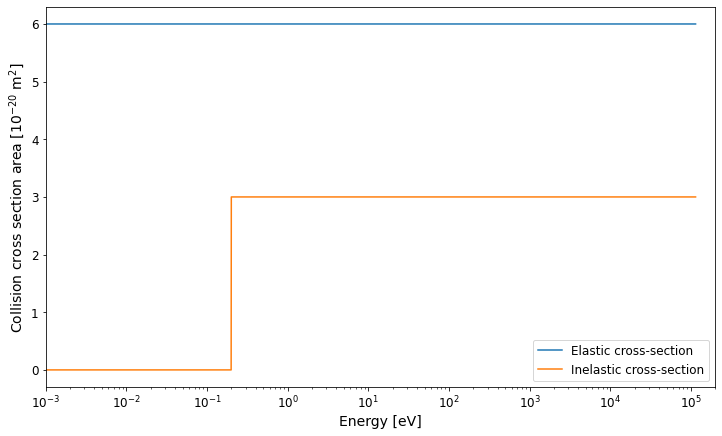

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(evList, sigmaList_e, label="Elastic cross-section")
ax.plot(evList, sigmaList_i, label="Inelastic cross-section")

ax.set_xscale("log")
ax.set_xlim(0.001, 200_000)
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("Collision cross section area [$10^{-20}$ $\mathrm{m}^2$]")
ax.legend()

plt.show()

The singular collision cross-sections are useful only for computing the type of collision. The property that is important to us is the total cross-section, i.e. the sum of all cross-sections for a specie. Based on the total cross-section we can calculate the probability of a collision in a single time-step.

In [9]:
vsqList = ptrSimData.pyGasCollisionVec.ptr[0].freqFtab.xVec.asList()
freqList_e = ptrSimData.pyGasCollisionVec.ptr[0].freqFtab.yVec.asList()
freqList_i = ptrSimData.pyGasCollisionVec.ptr[1].freqFtab.yVec.asList()

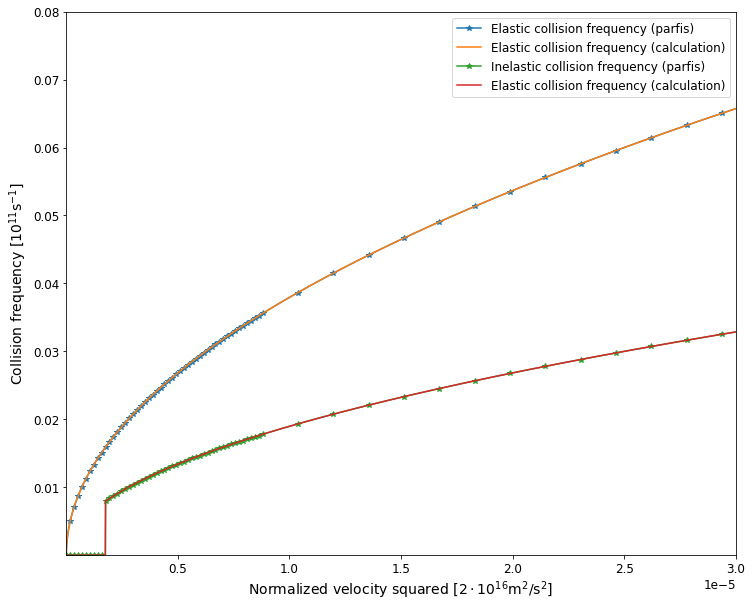

In [10]:
# Get coll. freq. from calculation
vList = np.sqrt(vsqList)*maxVel
yle_calc = np.ndarray(len(vList), dtype=float)
yli_calc = np.ndarray(len(vList), dtype=float)

JeV = 6.2415090744608e18
for i in range(len(vList)):
    # sigma(E) = sigma(mv^2/2 * JouleToeV_conversion_factor)
    yle_calc[i] = sigma_e(0.5*mkg*vList[i]**2*JeV)
    yli_calc[i] = sigma_i(0.5*mkg*vList[i]**2*JeV)

fle_v = N*yle_calc*1.0e-20*vList*dt
fli_v = N*yli_calc*1.0e-20*vList*dt

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

ax.plot(vsqList, freqList_e, label="Elastic collision frequency (parfis)", marker='*', markevery=20, linestyle=None)
ax.plot(vsqList, fle_v, label="Elastic collision frequency (calculation)")
ax.plot(vsqList, freqList_i, label="Inelastic collision frequency (parfis)", marker='*', markevery=20, linestyle=None)
ax.plot(vsqList, fli_v, label="Elastic collision frequency (calculation)")

ax.set_xlim(1e-11, 3.0e-5)
ax.set_ylim(4e-9, 0.8e-1)
ax.set_xlabel("Normalized velocity squared [${2 \cdot 10^{16}} \mathrm{m^2/s^2}$]")
ax.set_ylabel("Collision frequency [$\mathrm{10^{11}s^{-1}}$]")
ax.legend()

plt.show()

We can notice the non-linear tabulation in action. The collision frequency is given per timestep and we can see that is well below one, which is good - it means we have chosen a good time-step for the given particle mass.

## Probability for collision (total)

When we calculate the probability of a collision we use the total collision frequency. The total 
collision frequency is the sum of the collisional frequencies for each process. We use the total
collision frequency and not the total cross-section since the cross-sections can be defined for
different gas constituents in the case of gas mixtures. Since the collision frequency takes into 
account the gas density, we use the total collision frequency.

In [11]:
# Calculated
prob_col = 1.0 - np.exp(-(fle_v + fli_v))
# From code
prob_col_code_raw = ptrSimData.pyGasCollisionProbVec.ptr[0].yVec.asList()
colCnt = ptrSimData.pyGasCollisionProbVec.ptr[0].colCnt
rowCnt = ptrSimData.pyGasCollisionProbVec.ptr[0].rowCnt
prob_col_code = [[0]*rowCnt for i in range(colCnt)]
for i in range(colCnt):
    for j in range(rowCnt):
        prob_col_code[i][j] = prob_col_code_raw[j*colCnt + i]


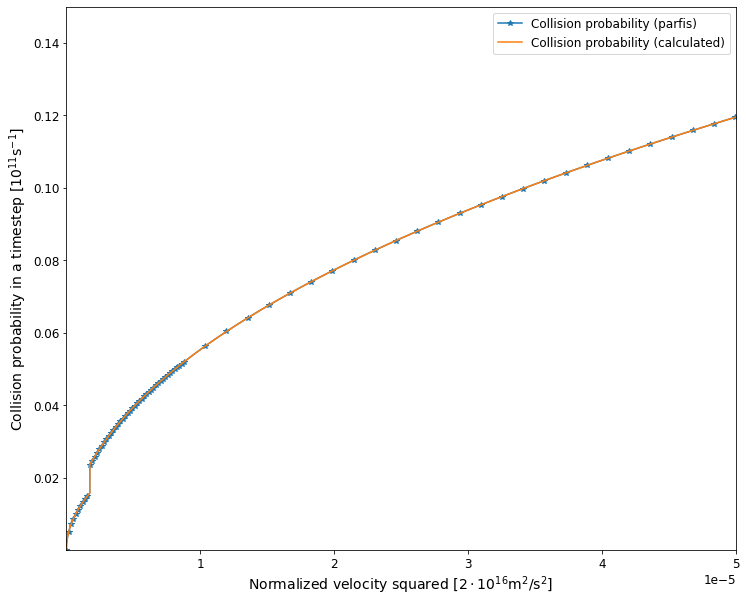

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# The last vector is the total collision probability
ax.plot(vsqList, prob_col_code[-1], label="Collision probability (parfis)" , marker='*', markevery=20, linestyle=None)
ax.plot(vsqList, prob_col, label="Collision probability (calculated)")

ax.set_xlim(1e-11, 5.0e-5)
ax.set_ylim(4e-9, 0.15)
ax.set_xlabel("Normalized velocity squared [${2 \cdot 10^{16}} \mathrm{m^2/s^2}$]")
ax.set_ylabel("Collision probability in a timestep [$\mathrm{10^{11}s^{-1}}$]")
ax.legend()

plt.show()

Since we have two collisions when we choose a number that explains that collision happened, we select the type of collision based on the relative value between different types of collisions. The relative collisions are scaled to the total collision at a given point, in this manner we only need one random variable to check if a collision happened and which type of collision happened. In the following example we will see the collision probability for a particle of squared velocity of ($4\cdot10^{-11} \mathrm{m^2/s^2}$)

In [13]:
rel_prob_e = prob_col*fle_v/(fle_v + fli_v)
np.nan_to_num(rel_prob_e, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

/tmp/ipykernel_20834/908629777.py:1: RuntimeWarning: invalid value encountered in divide
  rel_prob_e = prob_col*fle_v/(fle_v + fli_v)


array([0.        , 0.00112469, 0.00159018, ..., 0.66666666, 0.66666666,
       0.66666666])

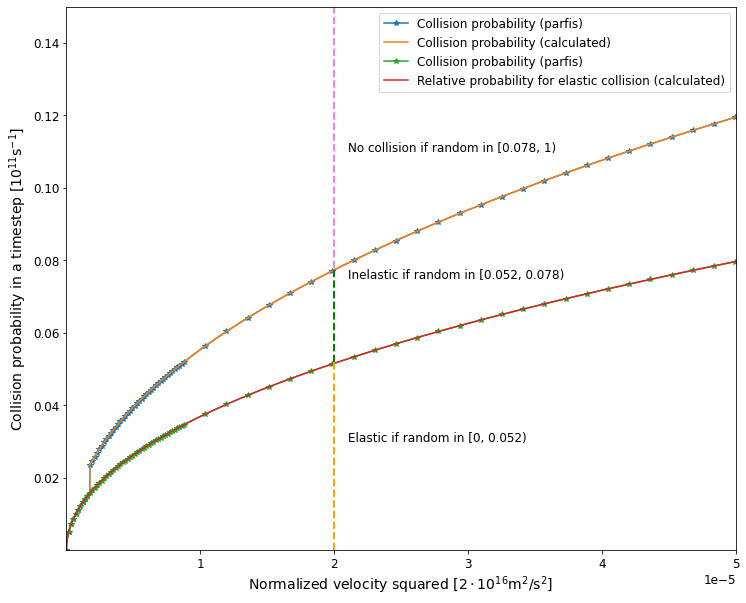

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# The last vector is the total collision probability
ax.plot(vsqList, prob_col_code[1], label="Collision probability (parfis)" , marker='*', markevery=20, linestyle=None)
ax.plot(vsqList, prob_col, label="Collision probability (calculated)")
# The first vector is the relative collision probability
ax.plot(vsqList, prob_col_code[0], label="Collision probability (parfis)" , marker='*', markevery=20, linestyle=None)
ax.plot(vsqList, rel_prob_e, label="Relative probability for elastic collision (calculated)")
ax.vlines(x=2e-5, ymin=4e-9, ymax=0.052, color='orange', ls='--', lw=2)
plt.text(x=2.1e-5, y=0.03, s="Elastic if random in [0, 0.052)", bbox=None)
ax.vlines(x=2e-5, ymin=0.052, ymax=0.078, color='green', ls='--', lw=2)
plt.text(x=2.1e-5, y=0.075, s="Inelastic if random in [0.052, 0.078)", bbox=None)
ax.vlines(x=2e-5, ymin=0.078, ymax=0.15, color='violet', ls='--', lw=2)
plt.text(x=2.1e-5, y=0.11, s="No collision if random in [0.078, 1)", bbox=None)


ax.set_xlim(1e-11, 5.0e-5)
ax.set_ylim(4e-9, 0.15)
ax.set_xlabel("Normalized velocity squared [${2 \cdot 10^{16}} \mathrm{m^2/s^2}$]")
ax.set_ylabel("Collision probability in a timestep [$\mathrm{10^{11}s^{-1}}$]")
ax.legend()

plt.show()